In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv(r'src\train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
categorials = list(data.dtypes[data.dtypes == object].index)
data[categorials] = data[categorials].fillna('nan')

continuous = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]
data[continuous] = data[continuous].fillna(-999)

data = pd.get_dummies(data[categorials]).join(data[continuous]).join(data['SalePrice'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['SalePrice']), data['SalePrice'], test_size=0.2)

In [5]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.8406563355095984

In [6]:
imp = pd.Series(rfr.feature_importances_)
imp.index = X_train.columns
imp = imp.sort_values(ascending=False)

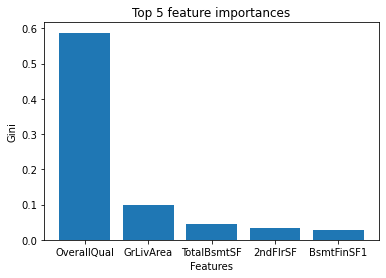

In [7]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.head().index, imp.head())
plt.show()

# Ensemble

In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [36]:
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV()
)

In [57]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [58]:
Regressor.score(X_train, y_train)

0.8325676767530447

In [59]:
scores_test = [Regressor.score(X_test, y_test)]
scores_train = [Regressor.score(X_train, y_train)]
for k in Regressor.named_estimators.keys():
    scores_test.append(Regressor.named_estimators_[k].score(X_test, y_test))
    scores_train.append(Regressor.named_estimators_[k].score(X_train, y_train))
    
scores_test = pd.Series(scores_test)
scores_test.index = ['Overall'] + list(Regressor.named_estimators.keys())

scores_train = pd.Series(scores_train)
scores_train.index = ['Overall'] + list(Regressor.named_estimators.keys())

In [60]:
scores_test

Overall                0.603959
LinearRegression       0.499110
KNeighborsRegressor    0.689783
DecisionTree           0.622127
dtype: float64

In [61]:
scores_train

Overall                0.832568
LinearRegression       0.942596
KNeighborsRegressor    0.770602
DecisionTree           1.000000
dtype: float64

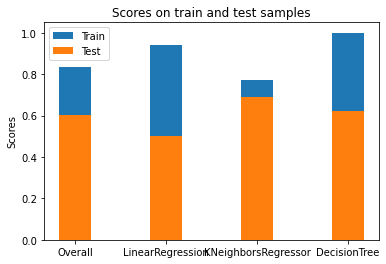

In [71]:
fig, ax = plt.subplots()

ax.bar(scores_train.index, scores_train, 0.35, label='Train')
ax.bar(scores_train.index, scores_test, 0.35, label='Test')

ax.set_ylabel('Scores')
ax.set_title('Scores on train and test samples')
ax.legend()

plt.show()